# Slabs SCs

In [23]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from Modelos   import *
from FuncsChern import *

import matplotlib.pyplot as plt

plt.rcParams.update({
    'text.usetex':    True,
    'font.family':    'serif',
    'font.serif':     ['Computer Modern'], 
    'axes.unicode_minus': False,
    'text.latex.preamble': r'\usepackage{amsfonts}',
})

plt.rcParams.update({
    "font.size": 18,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

def createletters(axs, Axis3D=[], coord=[0.08, 0.92], ni=0, SMALL_SIZE=20):
    import numpy as np
    letters = [r'\textbf{(a)}', r'\textbf{(b)}', r'\textbf{(c)}', r'\textbf{(d)}', r'\textbf{(e)}', r'\textbf{(f)}',
               r'\textbf{(g)}', r'\textbf{(h)}',r'\textbf{(i)}']
    # Aplanar axs si es un array multidimensional
    axs = np.ravel(axs)
    for n, ax in enumerate(axs):
        if n in Axis3D:
            ax.text2D(coord[0], coord[1], letters[max([n, ni])], transform=ax.transAxes, size=SMALL_SIZE, weight='bold')
        else:
            ax.text(coord[0], coord[1], letters[max([n, ni])], transform=ax.transAxes, size=SMALL_SIZE, weight='bold')


⏳ 1/3  Calculando ΔE_min(kz,G)…


G sweep:   0%|          | 0/1201 [00:00<?, ?it/s]

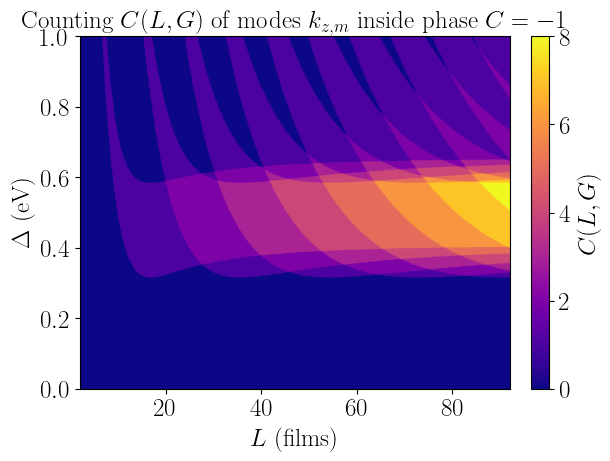

In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
C(L,G) map – count of kz‐quantised modes that fall in topological windows
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from joblib import Parallel, delayed
from tqdm.auto import tqdm

# ─────────────────────────── 1. MODELO Y PARRILLA ────────────────────
MU0, DELTA0      = 0.10, 0.1            # eV
T, M1            = 0.45, 10.0            # eV
c_lat, a_lat     = 2.0, 4.0              # Å
NK               = 2                     # kx-ky malla
G_vals           = np.linspace(0.0, 1.0, 1201)           # eV
kz_vals          = np.linspace(0.0, np.pi/c_lat, 1201)   # Å⁻¹
N_max            = 45                    # hasta 15 capas
thr_gap          = 7e-3                  # eV → gap “cerrado” si Δ < thr

# k-mesh (kx,ky)
kx = np.linspace(0.0, np.pi/a_lat, NK)
ky = np.linspace(0.0, np.pi/a_lat, NK)
kxg, kyg = np.meshgrid(kx, ky, indexing="ij")
cos_kx, cos_ky = np.cos(kxg*a_lat), np.cos(kyg*a_lat)
sin_kx, sin_ky = np.sin(kxg*a_lat), np.sin(kyg*a_lat)

M_grid_xy = -0.28 + 2*56.6/a_lat**2 * (2.0 - cos_kx - cos_ky)
A_grid    =  4.1 / a_lat * np.hypot(sin_kx, sin_ky)

# ─────────  helper 1: quartic coeffs (kx,ky) → ΔEmin(kz) ─
def quartic_coeffs(mu, G, D, kz):
    eps     = mu
    M1_term = 2*M1 / c_lat**2 * (1 - np.cos(kz * c_lat))
    M_grid  = M_grid_xy + M1_term

    D0 = eps**2 + D**2 - M_grid**2 - A_grid**2 - G**2 - T**2
    b0 = 4*G**2*(M_grid**2 + T**2) - 4*D**2*(M_grid**2 + A_grid**2)
    b1 = 4*(eps**2 + D**2)

    g0 = -64*G**2*T**2*D**2 * A_grid**2
    g1 =  64*G**2*(eps**2*M_grid**2 + eps**2*T**2 + T**2*D**2)

    a1 = 2*D0 - b1
    a0 = D0**2 - b0

    coeffs = np.stack([np.ones_like(a0),
                       2*a1,
                       a1**2 + 2*a0,
                       2*a0*a1 - g1,
                       a0**2 - g0], axis=-1)
    return coeffs.reshape(-1, 5)

def local_gap_from_coeffs(c, tol=1e-12):
    roots = np.roots(c)
    s     = roots.real[np.isreal(roots) & (roots.real > tol)]
    if s.size < 2:
        return np.inf
    E = np.sort(np.concatenate((-np.sqrt(s), np.sqrt(s))))
    return np.abs(E).min()

def gap_vs_kz(G):
    gaps = np.empty_like(kz_vals)
    for i, kz in enumerate(kz_vals):
        coeff = quartic_coeffs(MU0, G, DELTA0, kz)
        local = np.fromiter((local_gap_from_coeffs(c) for c in coeff),
                            dtype=float, count=coeff.shape[0])
        gaps[i] = local.min()
    return gaps

print("⏳ 1/3  Computing ΔE_min(kz,G)…")
gap_array = Parallel(n_jobs=-1)(
    delayed(gap_vs_kz)(G) for G in tqdm(G_vals, desc="G sweep", leave=False))
gap_array = np.asarray(gap_array).T      # (Nkz, NG)

# ────────────────────── 2. Topological mask C=0, C=-1, NaN ──────────────────
finite_gap = gap_array >= thr_gap            # True = gap open
labels, n_reg = ndimage.label(
    finite_gap,
    structure=[[0,1,0],[1,1,1],[0,1,0]]
)

phase_dict = {1: ( 0, "tab:red"),
              2: (-1, "tab:blue"),
              3: ( 0, "white")}           

code_map = np.full_like(labels, np.nan, dtype=float)
for lab, (code, _) in phase_dict.items():
    code_map[labels == lab] = code
code_phases = code_map                     # (Nkz, NG)

# ────────────────────── 3. Topological regions (C=-1) fixed G ───────────────
topo_intervals = []
for col in code_phases.T:                 
    idx = np.where(col == -1)[0]
    if idx.size == 0:
        topo_intervals.append([])
        continue
    splits = np.split(idx, np.where(np.diff(idx) > 1)[0]+1)
    intervals = [(kz_vals[s[0]], kz_vals[s[-1]]) for s in splits]
    topo_intervals.append(intervals)     
topo_intervals = np.asarray(topo_intervals, dtype=object)  # shape (NG,)

# ────────────────────── 4. Map  C(L,G)  ──────────────────────────────
L_vals = np.linspace(1, N_max+1,1000)             # 1…N_max
C_map  = np.zeros((L_vals.size, G_vals.size), dtype=int)

for iL, L in enumerate(L_vals):
    kz_modes = ((np.arange(L)+1) * np.pi) / ((L+1) * c_lat)   # (L,)
    for iG, intervals in enumerate(topo_intervals):
        if not intervals: 
            continue
        count = 0
        for kz in kz_modes:
           
            if any(lo - 1e-12 <= kz <= hi + 1e-12 for lo, hi in intervals):
                count += 1
        C_map[iL, iG] = count

# ────────────────────── 5. PLOT  C(L,G) ───────────────────────────────
fig, ax = plt.subplots(figsize=(6,4.5), constrained_layout=True)
im = ax.imshow(C_map.T, origin='lower',
               extent=[L_vals[0]*c_lat, L_vals[-1]*c_lat,
                       G_vals[0], G_vals[-1]],
               aspect='auto', cmap='plasma')

ax.set_xlabel(r'$L$  (films)')
ax.set_ylabel(r'$\Delta$  (eV)')
ax.set_title(r'Counting $C(L,G)$ of modes $k_{z,m}$ inside phase $C=-1$')
fig.colorbar(im, ax=ax, label=r'$C(L,G)$')
plt.show()

/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_1818/57304907.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_d    = plt.cm.get_cmap("tab20b", len(vals))


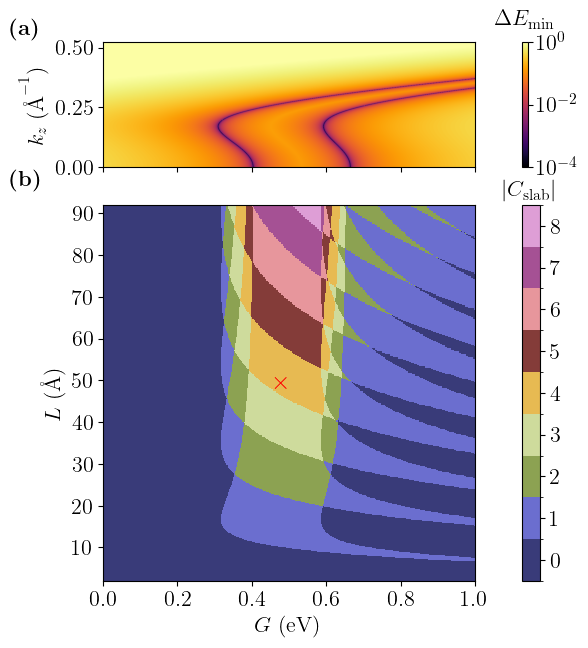

In [26]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, BoundaryNorm
import numpy as np

plt.rcParams.update({
    "font.size":      16,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize":16,
    "ytick.labelsize":16,
})

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 7),
    sharex=True,
    gridspec_kw={
        "height_ratios": [1, 3],  
        "hspace": 0.15            
    }
)

im1 = ax1.imshow(
    gap_array[:400, :],               
    origin="lower",
    extent=[G_vals[0], G_vals[-1], kz_vals[0], kz_vals[400]],
    aspect="auto",
    cmap="inferno",
    norm=LogNorm(vmin=1e-4, vmax=1.0)
)

ax1.set_yticks([0, 0.25, 0.5])
ax1.set_ylabel(r"$k_z \;(\mathrm{\AA}^{-1})$")

cbar1 = fig.colorbar(
    im1, ax=ax1,
    fraction=0.1,    
    pad=0.1         
)
cbar1.ax.set_title(r"$\Delta E_{\mathrm{min}}$", pad=12)

chern_map = np.abs(C_map)
vals      = np.sort(np.unique(chern_map))
cmap_d    = plt.cm.get_cmap("tab20b", len(vals))
bounds    = np.concatenate(([vals[0]-0.5], vals+0.5))
norm      = BoundaryNorm(bounds, cmap_d.N, clip=True)

im2 = ax2.imshow(
    chern_map, origin="lower",
    extent=[G_vals[0], G_vals[-1],
            L_vals[0]*c_lat, L_vals[-1]*c_lat],
    aspect="auto", interpolation="none",
    cmap=cmap_d, norm=norm
)

cbar2 = fig.colorbar(
    im2, ax=ax2, boundaries=bounds,
    ticks=vals, spacing="proportional",fraction=0.1,  
    pad=0.1 
)
cbar2.ax.set_title(r"$|C_\mathrm{slab}|$", pad=6)


ax2.set_xlabel(r"$G$ (eV)")
ax2.set_ylabel(r"$L$ (Å)")

ax2.set_yticks(np.arange(10, 91, 10))

ax2.text(
    0.46, 50.0, r'$\times$',
    va='center', ha='left',
    c='r', fontsize=18, fontweight='bold'
)


createletters((ax1, ax2), coord=[-0.25, 1.05], SMALL_SIZE=16)

#plt.savefig('Figs/SecIV/SlabsKZCHern.svg', bbox_inches='tight')
plt.show()

## Finite System

In [27]:
import sys

sys.path.append('..')

from FuncsChern import *
import numpy as np
import kwant

# Pauli matrices
sx = np.array([[0, 1],[1, 0]], dtype=complex)
sy = np.array([[0, -1j],[1j, 0]], dtype=complex)
sz = np.array([[1, 0],[0, -1]], dtype=complex)
s0 = np.eye(2, dtype=complex)

def sorted_eigs(ev):
    """ Function to sort the eigenvecs according to the eigenvalue order """ 
    evals, evecs = ev
    order = np.argsort(evals)
    return np.array(evals[order]), np.array(evecs[:, order])

from tqdm import tqdm  # Importar tqdm para la barra de progreso
import scipy.sparse.linalg as sla

def kron3(A, B, C):
    return np.kron(np.kron(A, B), C)

def Matrices_Gamma():

    Gz00 = kron3(sz,s0,s0)
    Gz0z = kron3(sz,s0,sz)
    G00x = kron3(s0,s0,sx)
    Gzzy = kron3(sz,sz,sy)
    Gzzz = kron3(sz,sz,sz)
    G0yy = kron3(s0,sy,sy)
    Gyyz = kron3(sy,sy,sz)
    Gxyz = kron3(sx,sy,sz)
    Gzyy = kron3(sz,sy,sy)
    Gzxx = kron3(sz,sx,sx)

    return Gz00, Gz0z, G00x, Gzzy, Gzzz, G0yy, Gyyz, Gzyy, Gxyz, Gzxx

Gz00, Gz0z, G00x, Gzzy, Gzzz, G0yy, Gyyz, Gzyy, Gxyz, Gzxx = Matrices_Gamma()


def Slab_BHZ_SC_kzky(params):
    a   = params["a"]
    c   = params["c"]
    L_y = params["L_y"]  
    L_z = params["L_z"]  

    lat = kwant.lattice.general([(a, 0), (0, c)], basis=[(0, 0)], norbs=8)

    def onsite(site, kx, a,c, C0, C1, C2, M0, M1, M2, A, G, Delta,T,B):
            z = int(site.tag[1])
            ck2_xy = 2.0 - np.cos(kx * a)
            ck2_z = 1
            epsilon_0 = C0 + (2 * C2 / (a ** 2)) * ck2_xy + (2 * C1 / (c ** 2)) * ck2_z
            M_0 = M0 + (2 * M2 / (a ** 2)) * ck2_xy + (2 * M1 / (c ** 2))* ck2_z
            
            OS_matrix = (
                epsilon_0 * Gz00 +
                (A/a) * (np.sin(kx * a) * G00x) +
                M_0 * Gz0z +
                G * Gzzz +
                Delta * Gyyz+ T*Gzyy)
            return OS_matrix


    def hopping_z(site1, site2, c, C1, M1, B,T):
        return (C1 / c**2) * Gz00 + (M1 / c**2) * Gz0z + (1j * B / (2 * c) * G0yy)

    def hopping_y(site1, site2, a, C2, M2, A):

        return (C2 / a**2) * Gz00 + (M2 / a**2) * Gz0z + (1j * A) / (2 * a) * Gzzy

    syst = kwant.Builder()

    
    def shape(pos):
        y, z = pos 
        return (0 <= y < L_y) and (0 <= z < L_z)

    
    syst[lat.shape(shape, (0, 0))] = onsite
    syst[kwant.builder.HoppingKind((1, 0), lat.sublattices[0], lat.sublattices[0])] = hopping_y
    syst[kwant.builder.HoppingKind((0, 1), lat.sublattices[0], lat.sublattices[0])] = hopping_z


    return syst.finalized()

In [28]:
H_params = {
        "L_z":10 * 5 , ## 10 * QLs 
        "L_y":300,
        "C0":0.1,
        "C2": 0,
        "C1": 0,
        "M0":-0.28, 
        "G":-0.46,
        "M1": 10,
        "M2": 56.59,
        "A" : 4.1,
        "B" : 0,  
        "T":0.45,
        "Delta": 0.1, 
        "a" : 4, 
        "c":  2, 
        "ky":0,
        "B":0,
        "kz":0
            }

syst = Slab_BHZ_SC_kzky(H_params)

In [29]:
def sorted_eigs(ev):
    """ Function to sort the eigenvecs according to the eigenvalue order """ 
    evals, evecs = ev
    order = np.argsort(evals)
    return np.array(evals[order]), np.array(evecs[:, order])

from tqdm import tqdm 
import scipy.sparse.linalg as sla
import scipy.sparse as ss




a= H_params["a"]
c= H_params["c"]

Ly = H_params["L_y"]
Lz = H_params["L_z"]

Ly = int(Ly/a)
Lz = int(Lz/c)


print([Ly,Lz])

N_k      = 31
bands   = 20
kx_values = np.linspace(-0.05, 0.05, N_k)

energy_kx = []
eigenvectors_kx = []
previous_evecs = None

for ki in tqdm(kx_values, desc="Computing eigensystem", unit="k-point"):
    H_params["kx"] = ki
    H_k = syst.hamiltonian_submatrix(params=H_params, sparse=True)


    ens, wfs = sla.eigsh(H_k.tocsc(), k=bands, sigma=0, return_eigenvectors=True)
    ens, wfs = sorted_eigs([ens, wfs])
    
    energy_kx.append(ens)
    eigenvectors_kx.append(wfs)



energy_kx = np.array(energy_kx)
eigenvectors_kx = np.array(eigenvectors_kx)
eigenvectors_kx = eigenvectors_kx.reshape([N_k, 8*Ly*Lz, bands])

[75, 25]


Computing eigensystem: 100%|██████████| 31/31 [02:43<00:00,  5.29s/k-point]


In [30]:
Q_mat = np.kron(np.eye(Ly*Lz), kron3(sz, s0, s0))

Nk, Nb = energy_kx.shape
Q_expect = np.empty((Nk, Nb))

Q_expect = np.einsum(
    'kan,ac,kcn->kn',               
    np.conj(eigenvectors_kx),        
    Q_mat,                           
    eigenvectors_kx,                 
    optimize=True                    
).real 

/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_1818/3737537283.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


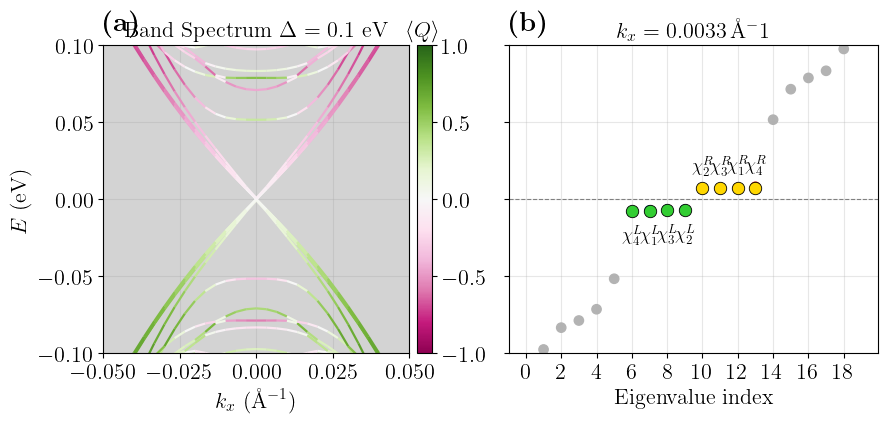

In [31]:
from matplotlib.collections import LineCollection
k_idx=N_k//2+1

fig, (ax_band, ax_spec) = plt.subplots(
    1, 2, figsize=(10, 4), sharey=True,
    gridspec_kw=dict(wspace=0.10)
)



Emin, Emax = -0.10, 0.10

cmap = plt.cm.PiYG              
norm = plt.Normalize(vmin=-1, vmax=1)

for j in range(Nb):
    x = kx_values                # (Nk,)
    y = energy_kx[:, j]          # (Nk,)
    q = Q_expect[:, j]           # (Nk,)

    pts      = np.column_stack([x, y]).reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)   # (Nk-1,2,2)

    q_seg = 0.5 * (q[:-1] + q[1:])

    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=1.6)
    lc.set_array(q_seg)
    ax_band.add_collection(lc)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax_band, pad=0.02)
cbar.ax.set_title(r'$\langle Q\rangle$')

ax_band.set_xlim(kx_values[0], kx_values[-1])
ax_band.set_ylim(Emin, Emax)
ax_band.set_xlabel(r'$k_x$ (\AA$^{-1}$)')
ax_band.set_ylabel(r'$E$ (eV)')
ax_band.set_title(r'Band Spectrum $\Delta = 0.1$ eV')
ax_band.set_facecolor('lightgrey')
ax_band.grid(alpha=0.4)


energies     = energy_kx[k_idx]
sort_idx     = np.argsort(energies)
energies_ord = energies[sort_idx]

i0 = np.argmin(np.abs(energies_ord))
lo, hi = max(i0 - 20, 0), min(i0 + 20, len(energies_ord))

x_vals = np.arange(lo, hi)
E_vals = energies_ord[lo:hi]

thr = 0.05                          
base_colors = ['tab:red'   if  0 < E <=  thr else
               'tab:blue'  if -thr <= E <  0 else
               '0.7' for E in E_vals]

ax_spec.scatter(x_vals, E_vals, s=45, c=base_colors, zorder=1)
ax_spec.axhline(0, ls='--', lw=0.8, color='grey')

m_order = [2, 3, 1, 4]         

sel_pos = [(band, E) for band, E in zip(idx_sel, E_sel) if E > 0]
sel_neg = [(band, E) for band, E in zip(idx_sel, E_sel) if E < 0]

sel_pos.sort(key=lambda t: t[1])          
sel_neg.sort(key=lambda t: abs(t[1]))

def highlight(selection, color, label_side, text_offset):
    """
    selection  : lista de (band_idx, E)
    color      : 'gold' o 'limegreen'
    label_side : r'^{R}' o r'^{L}'
    text_offset: desplazamiento vertical del texto
    """
    for rank, (band_idx, E) in enumerate(selection):
        
        where = np.where(sort_idx[lo:hi] == band_idx)[0]
        if not len(where):         
            continue
        x = x_vals[where[0]]


        ax_spec.scatter(x, E, s=80, color=color,
                        edgecolor='k', linewidth=0.6, zorder=4)

        m = m_order[rank]
        ax_spec.text(x, E + text_offset,
                     fr'$\chi_{{{m}}}{label_side}$',
                     ha='center', va='center',
                     fontsize=13, zorder=5)

highlight(sel_pos, 'gold',      r'^{R}', +0.015)
highlight(sel_neg, 'limegreen', r'^{L}', -0.015)

ax_spec.set_xlabel(r'Eigenvalue index')
ax_spec.set_title(fr'$k_x = {kx_values[k_idx]:.4f}\,$\AA$^{-1}$')
ax_spec.set_xticks(x_vals[::2])
ax_spec.grid(alpha=0.3)

plt.tight_layout()
createletters((ax_band, ax_spec), coord=[0, 1.05])
#plt.savefig('Figs/SecIV/BandsDelta01.svg', bbox_inches='tight')
plt.show()

kx selected: 0.003333333333333334
Lx, Lz (number of sites): [75, 25]


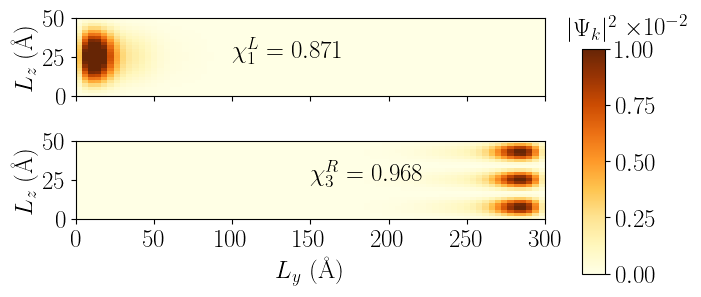

In [32]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

kx_selected_index = N_k//2+1

num_minima = 30

energies_for_kx = energy_kx[kx_selected_index, :]

sorted_indices = np.argsort(np.abs(energies_for_kx))[:num_minima]

min_values = [(band_idx, energies_for_kx[band_idx]) for band_idx in sorted_indices]

nbands = sorted_indices  


state0 = 4
state1 = 3
ki = [N_k // 2 + 1]
print("kx selected:", kx_values[ki[0]])

a = H_params["a"]
c = H_params["c"]

Ly = int(H_params["L_y"] / a)
Lz = int(H_params["L_z"] / c)

print("Lx, Lz (number of sites):", [Ly, Lz])


Dense   = kwant.operator.Density(syst, np.diag([1, 1, 1, 1,1,1,1,1]))
DenseSZ = kwant.operator.Density(syst, np.diag([1, -1, -1, 1,-1,1,-1,1]))
DensePQ = kwant.operator.Density(syst, np.diag([1, -1, 1, -1,1,-1,-1,1]))

u0 = eigenvectors_kx[ki[0], :, nbands[state0]]
u1 = eigenvectors_kx[ki[0], :, nbands[state1]]

en_state = energy_kx[ki[0], nbands[state0]]


avg    = np.sum(Dense(u0))
avg_SZ = np.sum(DenseSZ(u0))
avg_PQ = np.sum(DensePQ(u0))


legend_elements = [
    plt.Text(0, 0, fr'$<D> = {avg:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|S_z|\psi_k>| = {avg_SZ:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|P|\psi_k>| = {avg_PQ:.5f}$'),
    plt.Text(0, 0, fr'$E_k = {en_state:.6f}$'),
]

density_array0 = Dense(u0)
density_array1 = Dense(u1)

vmax = 1e-2
vmin = 0

norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='YlOrBr')

plt.rcParams.update({         
    "font.size": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

fig, axs = plt.subplots(2, 1, figsize=(10*0.75, 6*0.75), sharex=True)

extent = [0, Ly * a, 0, Lz * c]  

axs[0].imshow(density_array0.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='YlOrBr')
axs[1].imshow(density_array1.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='YlOrBr')

for ax in axs:
    ax.set_ylabel(r'$L_z$ ($\mathrm{\AA}$)')
    ax.set_yticks([0, 25, 50])               
    ax.set_yticklabels([0, 25,50])          
    ax.tick_params(labelsize=18)

axs[1].set_xlabel(r'$L_y$ ($\mathrm{\AA}$)')

fig.subplots_adjust(right=0.75, hspace=-0.45)

cbar_ax = fig.add_axes([0.8, 0.15, 0.03, 0.5])
cbar    = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title(r"$|\Psi_k|^2$", fontsize=18,pad=10)


cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

cbar.ax.yaxis.get_offset_text().set_visible(False)

cbar.ax.text(
    2.,          
    1.05,           
    r"$\times 10^{-2}$",
    transform=cbar.ax.transAxes,
    ha='left', va='bottom',
    fontsize=18
)

axs[0].text(100, 25, rf'$\chi_1^L = {chis[state0]:.3f}$', fontsize=18)
axs[1].text(150, 25, rf'$\chi_3^R = {chis[state1]:.3f}$', fontsize=18)

#plt.tight_layout()
plt.savefig('Figs/SecIV/StatesMaj.pdf',bbox_inches='tight')
plt.show()

## Numerical computation of Majoranas

In [ ]:
H_params = {
        "L_z":10 * 5 , ## 10 * QLs * SLABS
        "L_y":300,
        "C0":0.1, ## mu=56.3 meV [+ electrones, - huecos]
        "C2": 0,
        "C1": 0,
        "M0":-0.28, ## 0.28 eV
        "G":-0.46,
        "M1": 10,
        "M2": 56.59,
        "A" : 4.1,
        "B" : 0,  
        "T":0.45,
        "Delta": 0.1, ## 100 meV
        "a" : 4, ## 4  A
        "c":  2, ## Longitud QL / Nsitios
        "ky":0,
        "B":0,
        "kz":0
            }

syst = Slab_BHZ_SC_kzky(H_params)

In [41]:
cmap_reused=cmap_d

In [ ]:
import os
from functools import partial

import numpy as np
import scipy.sparse.linalg as sla
import kwant
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
from contextlib import contextmanager

### Parallelization for more speed, around ~1h

@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallBack(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *a, **kw):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*a, **kw)
    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallBack
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

def build_conjugation_operator(Ly: int, Lz: int, sx, s0) -> np.ndarray:
    """C = I_(Ly·Lz) ⊗ (sx ⊗ s0 ⊗ s0)"""
    return np.kron(np.eye(Ly * Lz), np.kron(np.kron(sx, s0), s0))


def solve_kpath(syst, params, kx_values, bands):
    energies, vecs = [], []
    for kx in kx_values:
        params['kx'] = kx
        Hk = syst.hamiltonian_submatrix(params=params,
                                        sparse=True)
        vals, wf = sla.eigsh(Hk, k=bands, sigma=0,
                             which='LM', return_eigenvectors=True)
        vals, wf = sorted_eigs([vals, wf])   
        energies.append(vals)
        vecs.append(wf)
    return np.asarray(energies), np.stack(vecs, axis=0)


def count_majorana(vecs_k0, conj_op, eh_op,
                   maj_threshold=0.5, charge_threshold=0.1, n_select=20):
    energies = vecs_k0['energies']
    wfs      = vecs_k0['wf']            # (dim, bands)

    idx       = np.abs(energies).argsort()[:n_select]
    sel_wfs   = wfs[:, idx]             # (dim, n_sel)

    maj_pol = np.abs(np.einsum('ij,ij->j',
                           sel_wfs,               #  u
                           conj_op @ np.conj(sel_wfs)))**2   # C·u*

    charge  = np.array([
    abs(np.sum(eh_op(sel_wfs[:, j])))
    for j in range(sel_wfs.shape[1])
    ])

    cond = (maj_pol > maj_threshold) & (charge < charge_threshold)
    return int(np.count_nonzero(cond))



def majorana_for_B(B, syst, base_params, kx_vals, bands, conj_op, eh_op):
    params = base_params.copy(); params['B'] = B

    energies, wfs = solve_kpath(syst, params, kx_vals, bands)
    vecs_k0 = {'energies': energies[0], 'wf': wfs[0]}

    return count_majorana(vecs_k0, conj_op, eh_op) // 2



a, c   = H_params['a'], H_params['c']
Ly     = int(H_params['L_y'] / a)
Nk     = 1
bands  = 14
kx_values = np.linspace(-0.05, 0.05, 31)
kx_idx = 31//2+1
kx_vals = np.array([kx_values[kx_idx]])

p2_vals = np.linspace(0, 2.2, 151)
p1_vals = np.arange(2, 71,2 )
Ct = np.zeros((len(p1_vals), len(p2_vals)), dtype=int)



os.environ.setdefault('OMP_NUM_THREADS', '1') 

for ix, p1 in enumerate(p1_vals):
  
    base_params = H_params.copy(); base_params['L_z'] = p1
    syst = Slab_BHZ_SC_kzky(base_params)   

    Lz  = int(p1 / c)
    conj_op = build_conjugation_operator(Ly, Lz, sx, s0)

    density_mat = np.diag([1, 1, 1, 1, -1, -1, -1, -1])
    eh_op = kwant.operator.Density(syst, density_mat)  

   
    worker = partial(majorana_for_B,
                     syst=syst,
                     base_params=base_params,
                     kx_vals=kx_vals,
                     bands=bands,
                     conj_op=conj_op,
                     eh_op=eh_op)

    desc = f"L = {p1:g} Å  (Ly={Ly}, Lz={Lz})"
    with tqdm_joblib(tqdm(total=len(p2_vals), desc=desc, leave=True)):
        Ct[ix, :] = Parallel(n_jobs=-1, backend="loky")(
        delayed(worker)(B) for B in p2_vals
    )


print(Ct)


L = 70 Å  (Ly=75, Lz=35): 100%|██████████| 151/151 [16:02<00:00,  6.37s/it]

Conteo total de modos con polarización de Majorana > 0.9, |Q| < 0.1
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 5 5 ... 0 0 0]
 [5 5 5 ... 0 0 0]
 [5 5 5 ... 0 0 0]]


In [43]:
cmap_reused=cmap_d
#np.save("Ct_arrayNew.npy", Ct)
Ct = np.load("Ct_arrayNew.npy")
p2_vals = np.linspace(0, 2.2, 151)
p1_vals = np.arange(2, 71, 2)

<>:44: SyntaxWarning: invalid escape sequence '\#'
<>:44: SyntaxWarning: invalid escape sequence '\#'
/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_2156/3689833756.py:44: SyntaxWarning: invalid escape sequence '\#'
  cbar.ax.set_title("\# Pairs", pad=6)


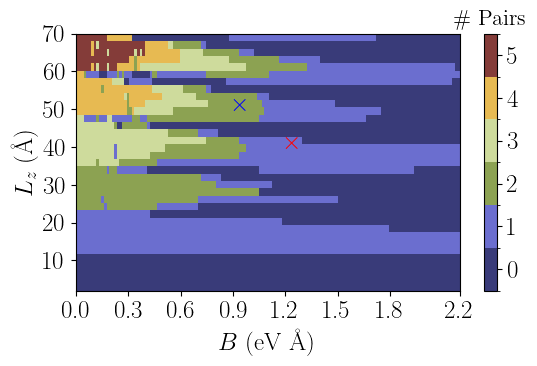

In [ ]:
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

vals   = np.sort(np.unique(Ct))[:6]                
bounds = np.concatenate(([vals[0] - 0.5], vals + 0.5))


if hasattr(cmap_reused, "colors"):                    
    cmap5 = ListedColormap(cmap_reused.colors[:6], name="cmap5")
else:                                                    
    cmap5 = ListedColormap(cmap_reused(np.linspace(0, 1, 6)), name="cmap5")
norm   = BoundaryNorm(bounds, cmap5.N, clip=True)  


fig, ax = plt.subplots(figsize=(6, 4))


im = ax.imshow(Ct,
               origin='lower',
               cmap=cmap5,
               norm=norm,
               aspect='auto',
               interpolation='none',
               extent=[p2_vals[0], p2_vals[-1], p1_vals[0], p1_vals[-1]])

ax.set_yticks(np.arange(10,71,10))               
ax.set_yticklabels(np.arange(10,71,10))

xticks = [0,0.3,0.6,0.9,1.2,1.5,1.8,2.2]
ax.set_xticks(xticks)
ax.set_xticklabels([f"{x:.1f}" for x in xticks])
ax.tick_params(labelsize=18)

cbar = fig.colorbar(im, ax=ax,
                    boundaries=bounds,
                    ticks=vals,
                    spacing='proportional')
cbar.ax.set_title("\# Pairs", pad=6)

# etiquetas
ax.set_xlabel(r"$B$ (eV Å)")
ax.set_ylabel(r"$L_z$ (Å)")

ax.text(0.9,50,r'$\times$',c='b')
ax.text(1.2,40,r'$\times$',c='r')

plt.tight_layout()

#plt.savefig('Figs/SecIV/NumericalB_B.pdf')
plt.show()

In [89]:
## Una QL son 10A, que son : Se-Bi-Se-Bi-Se. La c son aproximadamente 3 QLs

H_params = {
        "L_z":10 * 4 , ## 10 * QLs * SLABS
        "L_y":300,
        "C0":0.1, ## mu=56.3 meV [+ electrones, - huecos]
        "C2": 0,
        "C1": 0,
        "M0":-0.28, ## 0.28 eV
        "G":-0.46,
        "M1": 10,
        "M2": 56.59,
        "A" : 4.1,
        "B" : 1.2,  
        "T":0.45,
        "Delta": 0.1, ## 100 meV
        "a" : 4, ## 4  A
        "c":  2, ## Longitud QL / Nsitios
        "ky":0,
        "kz":0
            }

syst = Slab_BHZ_SC_kzky(H_params)

In [ ]:
def sorted_eigs(ev):
    """ Function to sort the eigenvecs according to the eigenvalue order """ 
    evals, evecs = ev
    order = np.argsort(evals)
    return np.array(evals[order]), np.array(evecs[:, order])

from tqdm import tqdm  
import scipy.sparse.linalg as sla
import scipy.sparse as ss




a= H_params["a"]
c= H_params["c"]

Ly = H_params["L_y"]
Lz = H_params["L_z"]

Ly = int(Ly/a)
Lz = int(Lz/c)


print([Ly,Lz])

N_k      = 61
bands   = 14
kx_values = np.linspace(-0.05, 0.05, N_k)

energy_kx = []
eigenvectors_kx = []
previous_evecs = None

for ki in tqdm(kx_values, desc="Computing eigensystem", unit="k-point"):
    H_params["kx"] = ki
    H_k = syst.hamiltonian_submatrix(params=H_params, sparse=True)


    ens, wfs = sla.eigsh(H_k.tocsc(), k=bands, sigma=0, return_eigenvectors=True)
    ens, wfs = sorted_eigs([ens, wfs])
    
    energy_kx.append(ens)
    eigenvectors_kx.append(wfs)



energy_kx = np.array(energy_kx)
eigenvectors_kx = np.array(eigenvectors_kx)
eigenvectors_kx = eigenvectors_kx.reshape([N_k, 8*Ly*Lz, bands])

[75, 20]


Calculando Autovalores/Autovectores: 100%|██████████| 61/61 [02:04<00:00,  2.05s/k-point]


In [ ]:
Q_mat = np.kron(np.eye(Ly*Lz), kron3(sz, s0, s0))

Nk, Nb = energy_kx.shape
Q_expect = np.empty((Nk, Nb))

Q_expect = np.einsum(
    'kan,ac,kcn->kn',               
    np.conj(eigenvectors_kx),       
    Q_mat,                          
    eigenvectors_kx,                
    optimize=True                   
).real 

Índices y energías seleccionadas en k=31:
   1) banda   6 : E = -0.00292 eV
   2) banda   7 : E =  0.00292 eV


/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_94262/1942324234.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


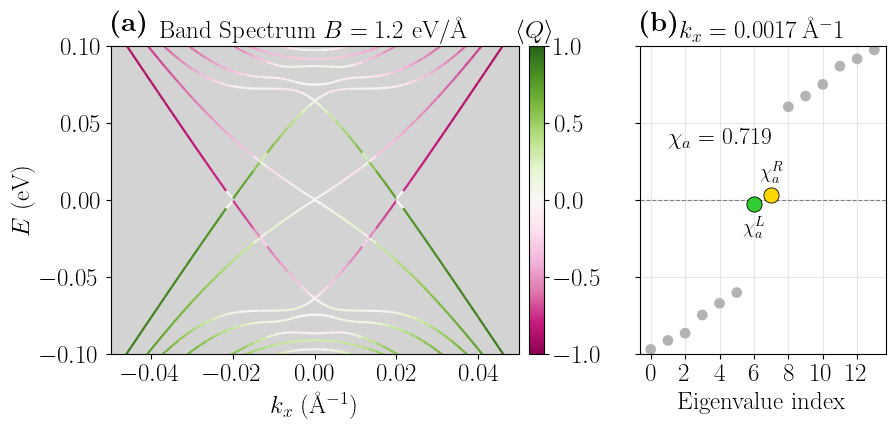

In [ ]:
k_idx      = N_k // 2 + 1                   
energies_k = energy_kx[k_idx, :]

idx_sel    = np.argsort(np.abs(energies_k))[:2]  
E_sel      = energies_k[idx_sel]

print("Índices y energías seleccionadas en k={}:".format(k_idx))
for i, (n, E) in enumerate(zip(idx_sel, E_sel), 1):
    print(f"  {i:2d}) banda {n:3d} : E = {E: .5f} eV")


L=Ly*Lz
C_mat  = np.kron(np.eye(L), kron3(sx, s0, s0))
chis   = []                                   

for n in idx_sel:
    u = eigenvectors_kx[k_idx, :, n]            # (4L,)
    chi = np.abs(np.vdot(np.conj(u), C_mat @ np.conj(u)))**2
    chis.append(chi)

chis = np.array(chis)

fig, (ax_band, ax_spec) = plt.subplots(
    1, 2, figsize=(10, 4), sharey=True,
    gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.10}
)


from matplotlib.collections import LineCollection

Emin, Emax = -0.1, 0.1
cmap = plt.cm.PiYG
norm = plt.Normalize(vmin=-1, vmax=1)

for j in range(Nb):
    x = kx_values                      # (Nk,)
    y = energy_kx[:, j]                # (Nk,)
    q = Q_expect[:, j]                 # (Nk,)

    pts      = np.column_stack([x, y]).reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)   # (Nk-1, 2, 2)


    q_seg = 0.5 * (q[:-1] + q[1:])      # (Nk-1,)

    lc = LineCollection(segments, cmap=cmap, norm=norm,
                        linewidths=1.6)
    lc.set_array(q_seg)
    ax_band.add_collection(lc)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax_band, pad=0.02)
cbar.ax.set_title(r'$\langle Q\rangle$')

Emin, Emax = -0.1, 0.1
ax_band.set_xlim(kx_values[0], kx_values[-1])
ax_band.set_ylim(Emin, Emax)
ax_band.set_xlabel(r'$k_x$ (\AA$^{-1}$)')
ax_band.set_ylabel(r'$E$ (eV)')
ax_band.set_title('Band Spectrum + Charge Projection')
ax_band.grid(alpha=0.3)
ax_band.set_facecolor('lightgrey')

pos_idx   = np.where(E_sel > 0)[0]
pos_order = pos_idx[np.argsort(E_sel[pos_idx])]

y_pos=np.linspace(0.04,0.06,2)

letters = ['a', 'b']              
y_pos = np.linspace(0.04, 0.06, 2) 

for rank, idx in enumerate(pos_order):         
    E      = y_pos[rank]
    chival = chis[idx]
    ax_spec.text(4, E,                         
                 fr'$\chi_{{{letters[rank]}}} = {chival:.3f}$',
                 fontsize=17, ha='center', va='center', zorder=5)

ax_band.set_xlim(kx_values[0], kx_values[-1])
ax_band.set_ylim(Emin, Emax)
ax_band.set_xlabel(r'$k_x$ (\AA$^{-1}$)')
ax_band.set_ylabel(r'$E$ (eV)')
ax_band.set_title(r'Band Spectrum $B=1.2$ eV/\AA')
ax_band.grid()

energies     = energy_kx[k_idx]
sort_idx     = np.argsort(energies)
energies_ord = energies[sort_idx]

i0 = np.argmin(np.abs(energies_ord))
lo, hi = max(i0-20, 0), min(i0+20, len(energies_ord))

x_vals = np.arange(lo, hi)
E_vals = energies_ord[lo:hi]

thr = 0.05
base_colors = ['gold'      if  0 < E <= thr else
               'limegreen' if -thr <= E < 0 else
               '0.7' for E in E_vals]

ax_spec.scatter(x_vals, E_vals, s=45, c=base_colors, zorder=1)
ax_spec.axhline(0, ls='--', lw=0.8, color='grey')

# ---------- χ_{a,b}^{R/L} -------------------
letters = ['a', 'b']           
dy = 0.008                    

sel_pos = [(band, E) for band, E in zip(idx_sel, E_sel) if E > 0]
sel_neg = [(band, E) for band, E in zip(idx_sel, E_sel) if E < 0]


sel_pos.sort(key=lambda t: t[1])
sel_neg.sort(key=lambda t: abs(t[1]))

def highlight(selection, col, side, dy_sign):
    for rank, (band_idx, E) in enumerate(selection):
        w = np.where(sort_idx[lo:hi] == band_idx)[0]
        if not len(w):
            continue
        x = x_vals[w[0]]

        ax_spec.scatter(x, E, s=120, color=col,
                        edgecolor='k', linewidth=0.6, zorder=3)

        m = letters[rank]          # 'a' o 'b'
        ax_spec.text(x, E + dy*dy_sign,
                     fr'$\chi_{m}$',
                     ha='center', va='center',
                     fontsize=14, zorder=4)

letters = ['a', 'b']      

def highlight(selection, col, side, dy_sign):
    dy = 0.015
    for rank, (band_idx, E) in enumerate(selection):
        w = np.where(sort_idx[lo:hi] == band_idx)[0]
        if not len(w):
            continue
        x = x_vals[w[0]]

     
        ax_spec.scatter(x, E, s=120, color=col,
                        edgecolor='k', linewidth=0.6, zorder=3)

        
        label = fr'$\chi^{{{side}}}_{{{letters[rank]}}}$'
        ax_spec.text(x, E + dy*dy_sign, label,
                     ha='center', va='center', fontsize=14, zorder=4)

highlight(sel_pos, 'gold',      'R', +1)
highlight(sel_neg, 'limegreen', 'L', -1)


ax_spec.set_xlabel(r'Eigenvalue index')
ax_spec.set_title(fr'$k_x = {kx_values[k_idx]:.4f}\,$\AA$^{-1}$')
ax_spec.set_xticks(x_vals[::2])
ax_spec.grid(alpha=0.3)


plt.tight_layout()
createletters((ax_band, ax_spec), coord=[0, 1.05])
#plt.savefig('Figs/SecIV/BandsB12.svg', bbox_inches='tight')
plt.show()

kx selected: 0.0016666666666666705
Lx, Lz (number of sites): [75, 25]


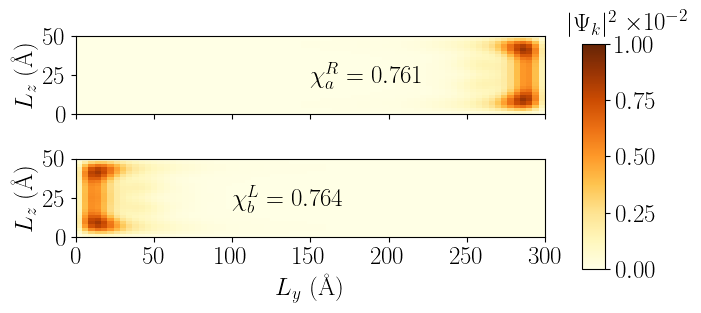

In [88]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

kx_selected_index = N_k//2+1

num_minima = 30

energies_for_kx = energy_kx[kx_selected_index, :]

sorted_indices = np.argsort(np.abs(energies_for_kx))[:num_minima]

min_values = [(band_idx, energies_for_kx[band_idx]) for band_idx in sorted_indices]

nbands = sorted_indices  


state0 = 0
state1 = 2
ki = [N_k // 2 + 1]
print("kx selected:", kx_values[ki[0]])

a = H_params["a"]
c = H_params["c"]

Ly = int(H_params["L_y"] / a)
Lz = int(H_params["L_z"] / c)

print("Lx, Lz (number of sites):", [Ly, Lz])


Dense   = kwant.operator.Density(syst, np.diag([1, 1, 1, 1,1,1,1,1]))
DenseSZ = kwant.operator.Density(syst, np.diag([1, -1, -1, 1,-1,1,-1,1]))
DensePQ = kwant.operator.Density(syst, np.diag([1, -1, 1, -1,1,-1,-1,1]))

u0 = eigenvectors_kx[ki[0], :, nbands[state0]]
u1 = eigenvectors_kx[ki[0], :, nbands[state1]]

en_state = energy_kx[ki[0], nbands[state0]]


avg    = np.sum(Dense(u0))
avg_SZ = np.sum(DenseSZ(u0))
avg_PQ = np.sum(DensePQ(u0))


legend_elements = [
    plt.Text(0, 0, fr'$<D> = {avg:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|S_z|\psi_k>| = {avg_SZ:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|P|\psi_k>| = {avg_PQ:.5f}$'),
    plt.Text(0, 0, fr'$E_k = {en_state:.6f}$'),
]

density_array0 = Dense(u0)
density_array1 = Dense(u1)

vmax = 1e-2
vmin = 0

norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='YlOrBr')

plt.rcParams.update({         
    "font.size": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

fig, axs = plt.subplots(2, 1, figsize=(10*0.75, 6*0.75), sharex=True)

extent = [0, Ly * a, 0, Lz * c]  

axs[0].imshow(density_array0.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='YlOrBr')
axs[1].imshow(density_array1.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='YlOrBr')

for ax in axs:
    ax.set_ylabel(r'$L_z$ ($\mathrm{\AA}$)')
    ax.set_yticks([0, 25, 50])               
    ax.set_yticklabels([0, 25,50])          
    ax.tick_params(labelsize=18)

axs[1].set_xlabel(r'$L_y$ ($\mathrm{\AA}$)')

fig.subplots_adjust(right=0.75, hspace=-0.45)

cbar_ax = fig.add_axes([0.8, 0.2, 0.03, 0.5])
cbar    = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title(r"$|\Psi_k|^2$", fontsize=18,pad=10)


cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

cbar.ax.yaxis.get_offset_text().set_visible(False)

cbar.ax.text(
    2.,          
    1.05,           
    r"$\times 10^{-2}$",
    transform=cbar.ax.transAxes,
    ha='left', va='bottom',
    fontsize=18
)

axs[0].text(150, 20, rf'$\chi^R_a = {chis[state0]:.3f}$', fontsize=18)
axs[1].text( 100, 20, rf'$\chi^L_b = {chis[state1]:.3f}$', fontsize=18)

#plt.tight_layout()
plt.savefig('Figs/SecIV/StatesMajB09.pdf',bbox_inches='tight')
plt.show()

## Heterostrcutures

In [ ]:
import sys

sys.path.append('..')

from FuncsChern import *
import numpy as np
import kwant

# Pauli matrices
sx = np.array([[0, 1],[1, 0]], dtype=complex)
sy = np.array([[0, -1j],[1j, 0]], dtype=complex)
sz = np.array([[1, 0],[0, -1]], dtype=complex)
s0 = np.eye(2, dtype=complex)

def sorted_eigs(ev):
    """ Function to sort the eigenvecs according to the eigenvalue order """ 
    evals, evecs = ev
    order = np.argsort(evals)
    return np.array(evals[order]), np.array(evecs[:, order])

from tqdm import tqdm  
import scipy.sparse.linalg as sla

def kron3(A, B, C):
    return np.kron(np.kron(A, B), C)

def Matrices_Gamma():

    Gz00 = kron3(sz,s0,s0)
    Gz0z = kron3(sz,s0,sz)
    G00x = kron3(s0,s0,sx)
    Gzzy = kron3(sz,sz,sy)
    Gzzz = kron3(sz,sz,sz)
    G0yy = kron3(s0,sy,sy)
    Gyyz = kron3(sy,sy,sz)
    Gxyz = kron3(sx,sy,sz)
    Gzyy = kron3(sz,sy,sy)
    Gzxx = kron3(sz,sx,sx)

    return Gz00, Gz0z, G00x, Gzzy, Gzzz, G0yy, Gyyz, Gzyy, Gxyz, Gzxx

Gz00, Gz0z, G00x, Gzzy, Gzzz, G0yy, Gyyz, Gzyy, Gxyz, Gzxx = Matrices_Gamma()


def Slab_BHZ_SC_kzky_HETERO(params):
    a   = params["a"]
    c   = params["c"]
    L_y = params["L_y"]  
    L_z = params["L_z"]  


    lat = kwant.lattice.general([(a, 0), (0, c)], basis=[(0, 0)], norbs=8)

    def onsite(site, kx, a,c, C0, C1, C2, M0vec,M0_func, M1, M2, A, G_func, Gvec, Delta, Delta_func,Delta2, Delta_func2, alpha,beta, T_func,Tvec):
            z = int(site.tag[1])
            ck2_xy = 2.0 - np.cos(kx * a)
            ck2_z = 1
            epsilon_0 = C0 + (2 * C2 / (a ** 2)) * ck2_xy + (2 * C1 / (c ** 2)) * ck2_z
            M_0 = M0_func(z, L_z/c, M0vec) + (2 * M2 / (a ** 2)) * ck2_xy + (2 * M1 / (c ** 2))* ck2_z
            
            OS_matrix = (
                epsilon_0 * Gz00 +
                (A/a) * (np.sin(kx * a) * G00x) +
                M_0 * Gz0z +
                G_func(z, L_z/c, Gvec) * Gzzz +
            np.real(Delta_func(z, alpha, Delta,L_z/c,c)+ Delta_func(z, alpha, Delta2,L_z/c,c)) * Gyyz+
            np.imag(Delta_func(z, alpha, Delta,L_z/c,c)+ Delta_func(z, alpha, Delta2,L_z/c,c)) * Gxyz
            +T_func(z, L_z/c, Tvec)*Gzyy)
            return OS_matrix

    def hopping_z(site1, site2, c, C1, M1, B,T):
        #z = int(site1.tag[1])
        return (C1 / c**2) * Gz00 + (M1 / c**2) * Gz0z + (1j * B / (2 * c) * G0yy)

    def hopping_y(site1, site2, a, C2, M2, A):

        return (C2 / a**2) * Gz00 + (M2 / a**2) * Gz0z + (1j * A) / (2 * a) * Gzzy

    syst = kwant.Builder()

    
    def shape(pos):
        y, z = pos 
        return (0 <= y < L_y) and (0 <= z < L_z)

    
    syst[lat.shape(shape, (0, 0))] = onsite
    syst[kwant.builder.HoppingKind((1, 0), lat.sublattices[0], lat.sublattices[0])] = hopping_y
    syst[kwant.builder.HoppingKind((0, 1), lat.sublattices[0], lat.sublattices[0])] = hopping_z

    return syst.finalized()

/opt/anaconda3/lib/python3.12/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [ ]:
def M0_func(z, L_z, M0vec):
    if z<4/8*L_z:
        return M0vec[0]
    else:
        if z<6/10*L_z:
            return M0vec[1]
        else:
            return M0vec[2]


def Delta_func(z, alpha, Delta,L,c):
    return np.abs(Delta * (1-alpha*z/(L)))*np.exp(1j*np.angle(Delta)) 

def Delta_func2(z, alpha, Delta,L,c):
    return np.abs(Delta * (alpha*z/(L)))*np.exp(1j*np.angle(Delta)) 

def G_func(z, L_z, Gvec):
    if z<4/8*L_z:
        return Gvec[0]
    else:
        if z<6/10*L_z:
            return Gvec[1]
        else:
            return Gvec[2]
        
def T_func(z, L_z, Tvec):
    if z<1/2*L_z:
        return Tvec[0]
    else:
        if z<L_z:
            return Tvec[1]
        else:
            return Tvec[2]

def B_func(z, L_z, Bvec):
    if z<1/2*L_z:
        return Bvec[0]
    else:
        if z<L_z:
            return Bvec[1]
        else:
            return Bvec[2]
H_params = {
        "L_z":10 * 8 , 
        "L_y":300,
        "C0":0.1, 
        "C2": 0,
        "C1": 0,
        "M0vec":[-0.28,-0.28,-0.28], 
        "Gvec":[-0.46,0.46, 0.46],  
        "M1": 10,
        "M2": 56.59,
        "A" : 4.1,
        "B" : 0,  
        "T":0.45, 
        "Tvec":[0.45,0.45,0.45],
        "Delta": 0.1, 
        "Delta2":0,
        "a" : 4, 
        "c":  2, 
        "alpha": 0,
        "beta":0,
        "M0_func": M0_func,
        "T_func": T_func,
        "G_func": G_func,
        "Delta_func": Delta_func, 
        "Delta_func2": Delta_func2,
        "ky":0,
            }

syst = Slab_BHZ_SC_kzky_HETERO(H_params)

In [ ]:
def sorted_eigs(ev):
    """ Function to sort the eigenvecs according to the eigenvalue order """ 
    evals, evecs = ev
    order = np.argsort(evals)
    return np.array(evals[order]), np.array(evecs[:, order])

from tqdm import tqdm  
import scipy.sparse.linalg as sla
import scipy.sparse as ss

a= H_params["a"]
c= H_params["c"]

Ly = H_params["L_y"]
Lz = H_params["L_z"]

Ly = int(Ly/a)
Lz = int(Lz/c)


print([Ly,Lz])

N_k      = 31
bands   = 20
kx_values = np.linspace(-0.05, 0.05, N_k)

energy_kx = []
eigenvectors_kx = []
previous_evecs = None

for ki in tqdm(kx_values, desc="Computing eigensystem", unit="k-point"):
    H_params["kx"] = ki
    H_k = syst.hamiltonian_submatrix(params=H_params, sparse=True)


    ens, wfs = sla.eigsh(H_k.tocsc(), k=bands, sigma=0, return_eigenvectors=True)
    ens, wfs = sorted_eigs([ens, wfs])
    
    energy_kx.append(ens)
    eigenvectors_kx.append(wfs)



energy_kx = np.array(energy_kx)
eigenvectors_kx = np.array(eigenvectors_kx)
eigenvectors_kx = eigenvectors_kx.reshape([N_k, 8*Ly*Lz, bands])

[75, 40]


Calculando Autovalores/Autovectores: 100%|██████████| 31/31 [03:32<00:00,  6.84s/k-point]


In [ ]:
Q_mat = np.kron(np.eye(Ly*Lz), kron3(sz, s0, s0))

Nk, Nb = energy_kx.shape
Q_expect = np.empty((Nk, Nb))

Q_expect = np.einsum(
    'kan,ac,kcn->kn',                
    np.conj(eigenvectors_kx),        
    Q_mat,                           
    eigenvectors_kx,                
    optimize=True                   
).real 

Índices y energías seleccionadas en k=16:
   1) banda   9 : E = -0.00697 eV
   2) banda  10 : E =  0.00697 eV
   3) banda  11 : E =  0.00697 eV
   4) banda   8 : E = -0.00697 eV
   5) banda  12 : E =  0.00759 eV
   6) banda   7 : E = -0.00759 eV
   7) banda  13 : E =  0.00759 eV
   8) banda   6 : E = -0.00759 eV


/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_1818/3257267250.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


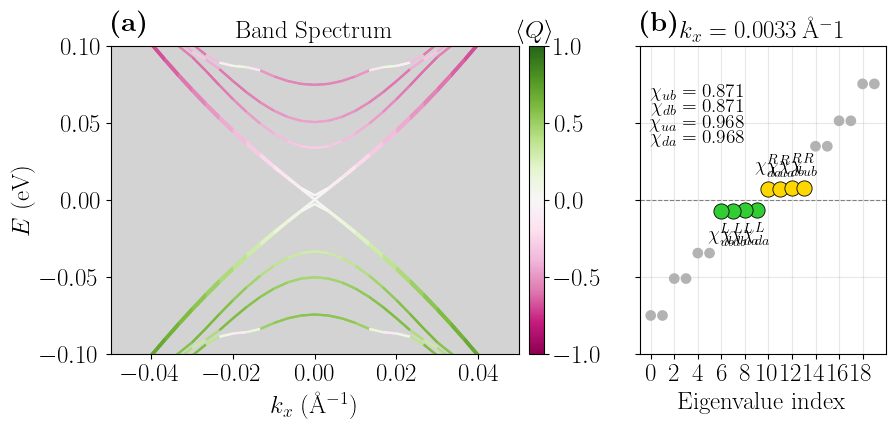

In [ ]:

k_idx      = N_k // 2 + 1                     
energies_k = energy_kx[k_idx, :]

idx_sel    = np.argsort(np.abs(energies_k))[:8] 
E_sel      = energies_k[idx_sel]

print("Índices y energías seleccionadas en k={}:".format(k_idx))
for i, (n, E) in enumerate(zip(idx_sel, E_sel), 1):
    print(f"  {i:2d}) banda {n:3d} : E = {E: .5f} eV")


L=Ly*Lz
C_mat  = np.kron(np.eye(L), kron3(sx, s0, s0))
chis   = []                                     

for n in idx_sel:
    u = eigenvectors_kx[k_idx, :, n]            
    chi = np.abs(np.vdot(np.conj(u), C_mat @ np.conj(u)))**2
    chis.append(chi)

chis = np.array(chis)

fig, (ax_band, ax_spec) = plt.subplots(
    1, 2, figsize=(10, 4), sharey=True,
    gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.10}
)


from matplotlib.collections import LineCollection

Emin, Emax = -0.1, 0.1
cmap = plt.cm.PiYG
norm = plt.Normalize(vmin=-1, vmax=1)

for j in range(Nb):
    x = kx_values                      # (Nk,)
    y = energy_kx[:, j]                # (Nk,)
    q = Q_expect[:, j]                 # (Nk,)


    pts      = np.column_stack([x, y]).reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)   # (Nk-1, 2, 2)


    q_seg = 0.5 * (q[:-1] + q[1:])      # (Nk-1,)


    lc = LineCollection(segments, cmap=cmap, norm=norm,
                        linewidths=1.6)
    lc.set_array(q_seg)
    ax_band.add_collection(lc)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax_band, pad=0.02)
cbar.ax.set_title(r'$\langle Q\rangle$')

Emin, Emax = -0.1, 0.1
ax_band.set_xlim(kx_values[0], kx_values[-1])
ax_band.set_ylim(Emin, Emax)
ax_band.set_xlabel(r'$k_x$ (\AA$^{-1}$)')
ax_band.set_ylabel(r'$E$ (eV)')
ax_band.set_title('Band Spectrum + Charge Projection')
ax_band.grid(alpha=0.3)
ax_band.set_facecolor('lightgrey')


pos_idx   = np.where(E_sel > 0)[0]
pos_order = pos_idx[np.argsort(E_sel[pos_idx])]


letters = ['da', 'ua','db','ub','d3','u3']             
y_pos = np.linspace(0.04, 0.09, 6)

for rank, idx in enumerate(pos_order):        
    E      = y_pos[rank]
    chival = chis[idx]
    ax_spec.text(4, E,                     
                 fr'$\chi_{{{letters[rank]}}} = {chival:.3f}$',
                 fontsize=14, ha='center', va='center', zorder=5)

ax_band.set_xlim(kx_values[0], kx_values[-1])
ax_band.set_ylim(Emin, Emax)
ax_band.set_xlabel(r'$k_x$ (\AA$^{-1}$)')
ax_band.set_ylabel(r'$E$ (eV)')
ax_band.set_title(r'Band Spectrum')
ax_band.grid()

energies     = energy_kx[k_idx]
sort_idx     = np.argsort(energies)
energies_ord = energies[sort_idx]

i0 = np.argmin(np.abs(energies_ord))
lo, hi = max(i0-20, 0), min(i0+20, len(energies_ord))

x_vals = np.arange(lo, hi)
E_vals = energies_ord[lo:hi]

thr = 0.025
base_colors = ['gold'      if  0 < E <= thr else
               'limegreen' if -thr <= E < 0 else
               '0.7' for E in E_vals]

ax_spec.scatter(x_vals, E_vals, s=45, c=base_colors, zorder=1)
ax_spec.axhline(0, ls='--', lw=0.8, color='grey')


letters = ['da', 'ua','db','ub','d3','u3']         
dy = 0.008                     

sel_pos = [(band, E) for band, E in zip(idx_sel, E_sel) if E > 0]
sel_neg = [(band, E) for band, E in zip(idx_sel, E_sel) if E < 0]


sel_pos.sort(key=lambda t: t[1])
sel_neg.sort(key=lambda t: abs(t[1]))

     

def highlight(selection, col, side, dy_sign):
    dy = 0.015
    for rank, (band_idx, E) in enumerate(selection):
        w = np.where(sort_idx[lo:hi] == band_idx)[0]
        if not len(w):
            continue
        x = x_vals[w[0]]

        ax_spec.scatter(x, E, s=120, color=col,
                        edgecolor='k', linewidth=0.6, zorder=3)

        #  χ^{R}_{a}   ó   χ^{L}_{b}
        label = fr'$\chi^{{{side}}}_{{{letters[rank]}}}$'
        ax_spec.text(x, E + dy*dy_sign, label,
                     ha='center', va='center', fontsize=14, zorder=4)

highlight(sel_pos, 'gold',      'R', +1)
highlight(sel_neg, 'limegreen', 'L', -1)

ax_spec.set_xlabel(r'Eigenvalue index')
ax_spec.set_title(fr'$k_x = {kx_values[k_idx]:.4f}\,$\AA$^{-1}$')
ax_spec.set_xticks(x_vals[::2])
ax_spec.grid(alpha=0.3)

plt.tight_layout()
createletters((ax_band, ax_spec), coord=[0, 1.05])
plt.savefig('Figs/SecIV/BandsG.svg', bbox_inches='tight')
plt.show()

kx selected: 0.003333333333333334
Lx, Lz (number of sites): [75, 40]


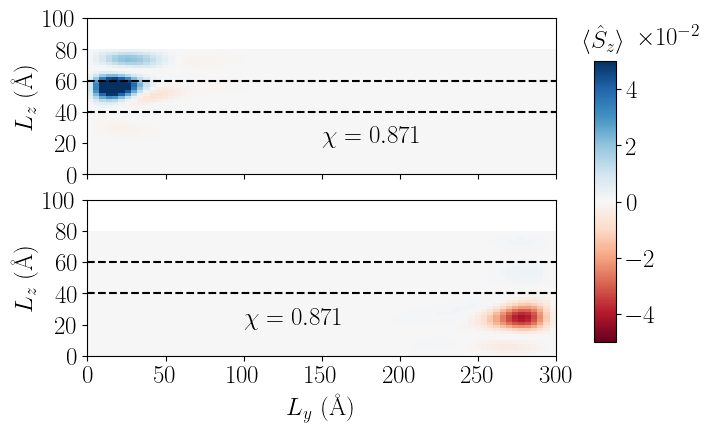

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

kx_selected_index = N_k//2+1

num_minima = 30

energies_for_kx = energy_kx[kx_selected_index, :]

sorted_indices = np.argsort(np.abs(energies_for_kx))[:num_minima]

min_values = [(band_idx, energies_for_kx[band_idx]) for band_idx in sorted_indices]

nbands = sorted_indices  

state0 = 4
state1 = 6
ki = [N_k // 2 + 1]
print("kx selected:", kx_values[ki[0]])

a = H_params["a"]
c = H_params["c"]

Ly = int(H_params["L_y"] / a)
Lz = int(H_params["L_z"] / c)

print("Lx, Lz (number of sites):", [Ly, Lz])

Dense   = kwant.operator.Density(syst, np.diag([1, 1, 1, 1,1,1,1,1]))
DenseSZ = kwant.operator.Density(syst, np.diag([1, -1, -1, 1,-1,1,-1,1]))
DensePQ = kwant.operator.Density(syst, np.diag([1, -1, 1, -1,1,-1,-1,1]))

u0 = eigenvectors_kx[ki[0], :, nbands[state0]]
u1 = eigenvectors_kx[ki[0], :, nbands[state1]]

en_state = energy_kx[ki[0], nbands[state0]]

avg    = np.sum(Dense(u0))
avg_SZ = np.sum(DenseSZ(u0))
avg_PQ = np.sum(DensePQ(u0))

legend_elements = [
    plt.Text(0, 0, fr'$<D> = {avg:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|S_z|\psi_k>| = {avg_SZ:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|P|\psi_k>| = {avg_PQ:.5f}$'),
    plt.Text(0, 0, fr'$E_k = {en_state:.6f}$'),
]

density_array0 = DenseSZ(u0)
density_array1 = DenseSZ(u1)

vmax = 5e-3
vmin = -5e-3

norm = Normalize(vmin=vmin, vmax=vmax)
#sm = ScalarMappable(norm=norm, cmap='YlOrBr')
sm = ScalarMappable(norm=norm, cmap='RdBu')

plt.rcParams.update({         
    "font.size": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

fig, axs = plt.subplots(2, 1, figsize=(10*0.75, 6*0.75), sharex=True,sharey=True)

extent = [0, Ly * a, 0, Lz * c]  

axs[0].imshow(density_array0.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu')
axs[1].imshow(density_array1.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu')

for ax in axs:
    ax.set_ylabel(r'$L_z$ ($\mathrm{\AA}$)')
    ax.set_yticks([0, 20, 40,60,80,100])               
    ax.set_yticklabels([0, 20,40,60,80,100])          
    ax.tick_params(labelsize=18)
    ax.axhline(40,ls='--',c='k')
    ax.axhline(60,ls='--',c='k')

axs[1].set_xlabel(r'$L_y$ ($\mathrm{\AA}$)')

fig.subplots_adjust(right=0.75, hspace=0.1)

cbar_ax = fig.add_axes([0.8, 0.15, 0.03, 0.625])
cbar    = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title(r"$\langle \hat{S}_z \rangle$", fontsize=18,pad=10)

cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

cbar.ax.yaxis.get_offset_text().set_visible(False)

cbar.ax.text(
    2.,          
    1.05,           
    r"$\times 10^{-2}$",
    transform=cbar.ax.transAxes,
    ha='left', va='bottom',
    fontsize=18
)

axs[0].text(150, 20, rf'$\chi = {chis[state0]:.3f}$', fontsize=18)
axs[1].text( 100, 20, rf'$\chi = {chis[state1]:.3f}$', fontsize=18)

#plt.tight_layout()
#plt.savefig('Figs/SecIV/StatesMajHeteroSGvaluesIns.svg')
plt.show()

kx selected: 0.003333333333333334
Lx, Lz (number of sites): [75, 50]


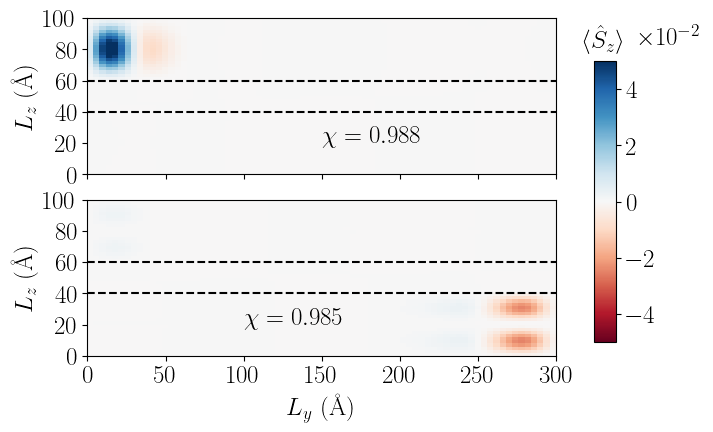

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

kx_selected_index = N_k//2+1

num_minima = 30

energies_for_kx = energy_kx[kx_selected_index, :]

sorted_indices = np.argsort(np.abs(energies_for_kx))[:num_minima]

min_values = [(band_idx, energies_for_kx[band_idx]) for band_idx in sorted_indices]

nbands = sorted_indices  

state0 = 6
state1 = 3
ki = [N_k // 2 + 1]
print("kx selected:", kx_values[ki[0]])

a = H_params["a"]
c = H_params["c"]

Ly = int(H_params["L_y"] / a)
Lz = int(H_params["L_z"] / c)

print("Lx, Lz (number of sites):", [Ly, Lz])

Dense   = kwant.operator.Density(syst, np.diag([1, 1, 1, 1,1,1,1,1]))
DenseSZ = kwant.operator.Density(syst, np.diag([1, -1, -1, 1,-1,1,-1,1]))
DensePQ = kwant.operator.Density(syst, np.diag([1, -1, 1, -1,1,-1,-1,1]))

u0 = eigenvectors_kx[ki[0], :, nbands[state0]]
u1 = eigenvectors_kx[ki[0], :, nbands[state1]]

en_state = energy_kx[ki[0], nbands[state0]]

avg    = np.sum(Dense(u0))
avg_SZ = np.sum(DenseSZ(u0))
avg_PQ = np.sum(DensePQ(u0))

legend_elements = [
    plt.Text(0, 0, fr'$<D> = {avg:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|S_z|\psi_k>| = {avg_SZ:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|P|\psi_k>| = {avg_PQ:.5f}$'),
    plt.Text(0, 0, fr'$E_k = {en_state:.6f}$'),
]

density_array0 = DenseSZ(u0)
density_array1 = DenseSZ(u1)

vmax = 5e-3
vmin = -5e-3

norm = Normalize(vmin=vmin, vmax=vmax)
#sm = ScalarMappable(norm=norm, cmap='YlOrBr')
sm = ScalarMappable(norm=norm, cmap='RdBu')

plt.rcParams.update({         
    "font.size": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

fig, axs = plt.subplots(2, 1, figsize=(10*0.75, 6*0.75), sharex=True,sharey=True)

extent = [0, Ly * a, 0, Lz * c]  

axs[0].imshow(density_array0.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu')
axs[1].imshow(density_array1.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='RdBu')

for ax in axs:
    ax.set_ylabel(r'$L_z$ ($\mathrm{\AA}$)')
    ax.set_yticks([0, 20, 40,60,80,100])               
    ax.set_yticklabels([0, 20,40,60,80,100])          
    ax.tick_params(labelsize=18)
    ax.axhline(40,ls='--',c='k')
    ax.axhline(60,ls='--',c='k')

axs[1].set_xlabel(r'$L_y$ ($\mathrm{\AA}$)')

fig.subplots_adjust(right=0.75, hspace=0.1)

cbar_ax = fig.add_axes([0.8, 0.15, 0.03, 0.625])
cbar    = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title(r"$\langle \hat{S}_z \rangle$", fontsize=18,pad=10)

cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

cbar.ax.yaxis.get_offset_text().set_visible(False)

cbar.ax.text(
    2.,          
    1.05,           
    r"$\times 10^{-2}$",
    transform=cbar.ax.transAxes,
    ha='left', va='bottom',
    fontsize=18
)

axs[0].text(150, 20, rf'$\chi = {chis[state0]:.3f}$', fontsize=18)
axs[1].text( 100, 20, rf'$\chi = {chis[state1]:.3f}$', fontsize=18)

#plt.tight_layout()
#plt.savefig('Figs/SecIV/StatesMajHeteroSGvaluesInsB.svg')
plt.show()